In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import constants
import copy

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
nodes = gpd.read_file("data/ego/nodes.shp")
edges = gpd.read_file("data/ego/edges.shp")

# set indexes for the GeoDataFrame (just for to be sure)
nodes = nodes.set_index("osmid")
edges = edges.set_index(['u', 'v', 'key'])

# convert to osmnx graph
G = ox.utils_graph.graph_from_gdfs(nodes, edges)

In [3]:
nodes.head()

,osmid_orig,x,y,street_cou,POI,edu,health,transp,food,lon,lat,highway,ref,geometry
osmid,,,,,,,,,,,,,,
0,"[141540485, 254672751, 197522982, 254672878, 2...",724701.900173,5.034203e+06,0,transp,1,1,1,1,NaN,NaN,None,None,POINT (724701.900 5034203.206)
235,"[197523004, 345286935, 1706766370, 559475298, ...",724667.547169,5.034311e+06,0,None,1,1,1,1,NaN,NaN,None,None,POINT (724667.547 5034311.202)
233,243488899,724825.279648,5.034265e+06,5,None,1,1,1,1,11.873938,45.425744,None,None,POINT (724825.280 5034265.244)
628,"[2522360857, 243486447, 2522360875, 2522360879...",724832.620828,5.033955e+06,0,transp,1,1,1,1,NaN,NaN,None,None,POINT (724832.621 5033954.570)
643,243487238,724773.189779,5.034232e+06,3,None,1,1,1,1,11.873258,45.425462,None,None,POINT (724773.190 5034231.991)


In [4]:
# keep copies of the original graph for betweeneess centrality and closeness centrality updates
G_bc = copy.deepcopy(G)
G_cc = copy.deepcopy(G)

category: edu	 covered nodes: 3218
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 2244
number of ndoes after removing small components: 1872
number of communities: 52


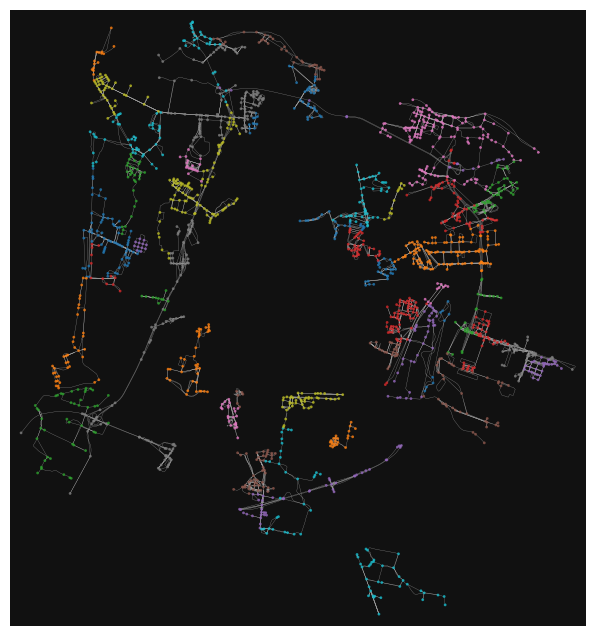

category: health	 covered nodes: 2565
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 2897
number of ndoes after removing small components: 2724
number of communities: 55


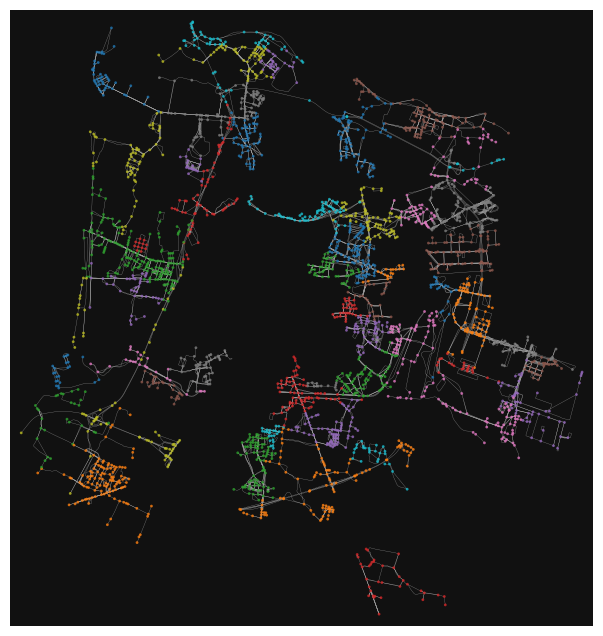

category: transp	 covered nodes: 4745
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 717
number of ndoes after removing small components: 486
number of communities: 31


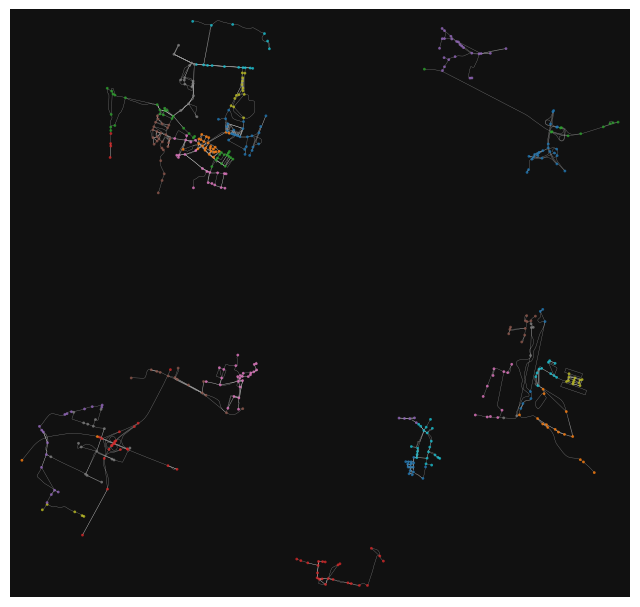

category: food	 covered nodes: 3669
number of nodes before removing covered nodes: 5462
number of nodes after removing covered nodes: 1793
number of ndoes after removing small components: 1519
number of communities: 46


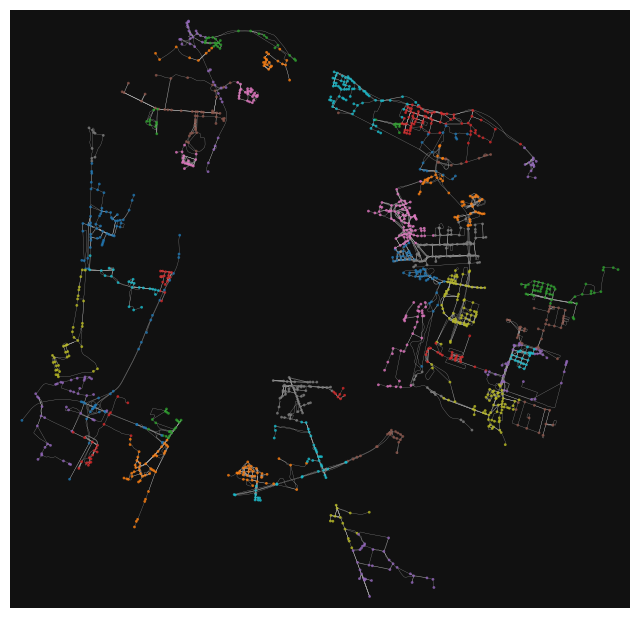

total number of communities: 184


In [5]:
total_communities = 0
for category in constants.CATEGORIES:
    G_copy = copy.deepcopy(G)

    # remove already covered nodes
    covered_nodes = []
    for node, data in G.nodes(data=True):
        covered = data.get(category, False)
        if covered:
            covered_nodes.append(node)
        
    print(f"category: {category}\t covered nodes: {len(covered_nodes)}")

    print(f"number of nodes before removing covered nodes: {len(G_copy.nodes())}")
    G_copy.remove_nodes_from(covered_nodes)
    print(f"number of nodes after removing covered nodes: {len(G_copy.nodes())}")

    # remove connected components with less than 20 nodes (small optimization, not worth it to cover this isolated zones)
    rmv_list = []
    for c in sorted(nx.connected_components(ox.utils_graph.get_undirected(G_copy)), key=len, reverse=True):
        if len(c) <= 20:
            rmv_list.extend(list(c))
    G_copy.remove_nodes_from(rmv_list)
    print(f"number of ndoes after removing small components: {len(G_copy.nodes())}")

    # use louvain algorithm for finding communities
    communities = nx.community.louvain_communities(G_copy, weight="time") # list of sets (communities)
    print(f"number of communities: {len(communities)}")
    total_communities += len(communities)

    # color mapping for plotting
    color_map = {}
    for i, community in enumerate(communities):
        # set node attribute on the graph
        # the attribute is "community": number
        node_dict = {node_id: {"community": i} for node_id in community}
        nx.set_node_attributes(G_copy, node_dict)
    
        # color map for plotting
        color = f'C{i}'
        for node in community:
            color_map[node] = color

    # plot the graph
    fig, ax = ox.plot_graph(
        G_copy,
        node_color=[color_map[node] for node in G_copy.nodes()],
        node_size=4,
        node_alpha=0.8,
        edge_linewidth=0.2,
        edge_color="#999999",
    )

    for community in communities:
        sub = nx.subgraph(G_copy,community)
    
        bc = nx.betweenness_centrality(sub, weight="time")
        cc = nx.closeness_centrality(sub, distance="time")
        max_key_bc = max(bc, key=bc.get)
        max_key_cc = max(cc, key=cc.get)

        G_bc.nodes[max_key_bc]["bc"] = True
        G_bc.nodes[max_key_bc][f"bc_{category}"] = True
        
        G_cc.nodes[max_key_cc]["cc"] = True
        G_cc.nodes[max_key_cc][f"cc_{category}"] = True
print(f"total number of communities: {total_communities}")

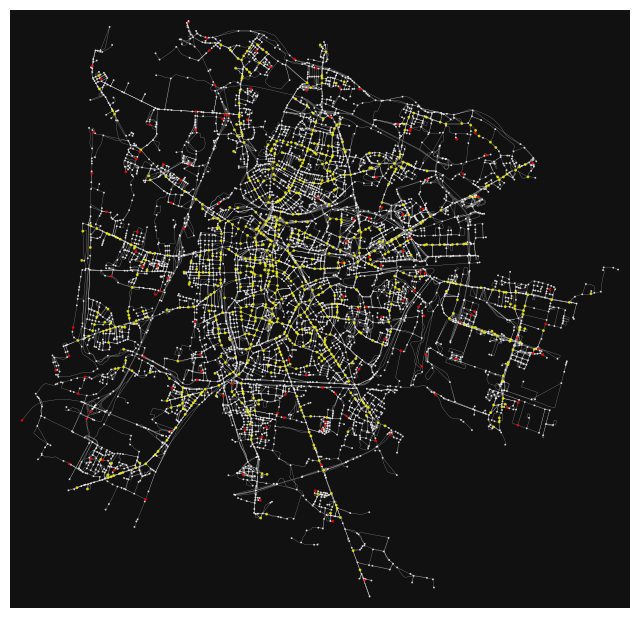

In [6]:
## color the nodes: white - normal; yellow - POIs; red - new POIs
# here's the code for the Closeness centrality
node_colors = {}
node_sizes = {}
s=0
for node, data in G_cc.nodes(data=True):
    poi = data.get("POI", None)
    poi_cc = data.get("cc", False)
    if poi in constants.CATEGORIES:
        node_colors[node] = "yellow"
        node_sizes[node] = 4
    elif poi_cc:
        node_colors[node] = "red"
        node_sizes[node] = 4
    else:
        node_colors[node] = "white"
        node_sizes[node] = 1.8

    for c in constants.CATEGORIES:
        cc = data.get(f"cc_{c}", False)
        if cc:
            s+=1
        

assert s == total_communities

nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

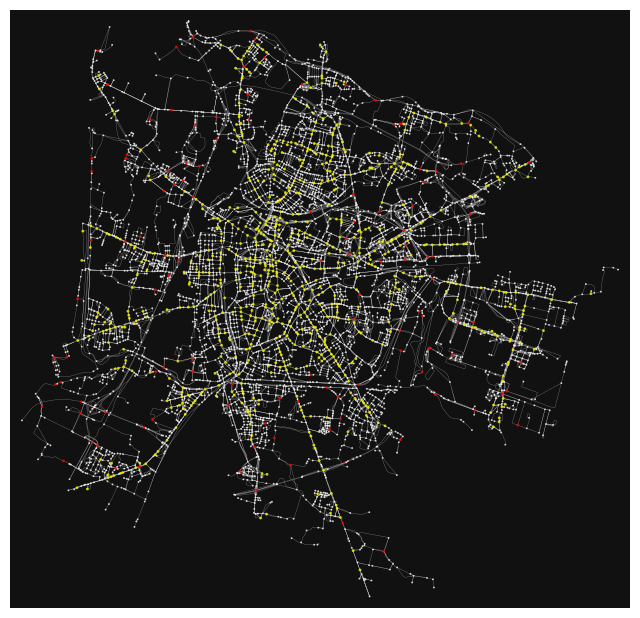

In [7]:
## color the nodes: white - normal; yellow - POIs; red - new POIs
# here's the code for the Betweenness centrality
node_colors = {}
node_sizes = {}
s = 0
for node, data in G_bc.nodes(data=True):
    poi = data.get("POI", None)
    poi_bc = data.get("bc", False)
    if poi in constants.CATEGORIES:
        node_colors[node] = "yellow"
        node_sizes[node] = 4
    elif poi_bc:
        node_colors[node] = "red"
        node_sizes[node] = 4
    else:
        node_colors[node] = "white"
        node_sizes[node] = 1.8

    for c in constants.CATEGORIES:
        bc = data.get(f"bc_{c}", False)
        if bc:
            s+=1

assert s == total_communities

nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [10]:
nodes = ox.graph_to_gdfs(G_bc, edges=False)
nodes[nodes["bc_food"]==True]

,osmid_orig,x,y,street_cou,POI,edu,health,transp,food,lon,lat,bc,bc_health,bc_edu,highway,bc_food,ref,bc_transp,geometry
osmid,,,,,,,,,,,,,,,,,,,
261,"[11046614165, 1835507021, 11046614173, 1104661...",728079.619797,5.032437e+06,0,NaN,1,1,1,0,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,POINT (728079.620 5032436.954)
405,"[2131164182, 618264065, 7095200858, 330343216,...",728576.374061,5.032502e+06,0,NaN,0,0,1,0,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,POINT (728576.374 5032501.952)
255,"[5757241977, 1132461615, 1523206270, 848344089...",728055.657340,5.033068e+06,0,NaN,1,1,1,0,NaN,NaN,True,NaN,NaN,NaN,True,NaN,NaN,POINT (728055.657 5033067.720)
1995,"[330209047, 1522935412, 1522935424, 330209048,...",729494.214317,5.033430e+06,0,NaN,0,0,1,0,NaN,NaN,True,NaN,True,NaN,True,NaN,NaN,POINT (729494.214 5033430.112)
351,210473174,721598.768195,5.029143e+06,3,NaN,0,0,0,0,11.830443,45.380723,True,NaN,NaN,NaN,True,NaN,NaN,POINT (721598.768 5029142.905)
697,243537007,723998.639532,5.035522e+06,4,NaN,0,0,1,0,11.863957,45.437306,True,NaN,NaN,NaN,True,NaN,NaN,POINT (723998.640 5035521.746)
247,292678505,729298.058039,5.034511e+06,3,NaN,0,0,0,0,11.931154,45.426506,True,NaN,True,motorway_junction,True,19,True,POINT (729298.058 5034511.500)
849,"[5306725361, 5645296659, 5645296656, 530672536...",729235.589557,5.031077e+06,0,NaN,0,0,1,0,NaN,NaN,True,True,True,NaN,True,NaN,NaN,POINT (729235.590 5031076.800)
4524,920842067,727981.102319,5.028541e+06,3,NaN,0,0,1,0,11.911581,45.373265,True,NaN,NaN,NaN,True,NaN,NaN,POINT (727981.102 5028541.110)


In [9]:
ox.save_graph_shapefile(G_bc, filepath="data/communities_bc", encoding="utf-8")
ox.save_graph_shapefile(G_cc, filepath="data/communities_cc", encoding="utf-8")

# Results
Repeating the coverage analysis with the updated graph yields the following results.

## Closeness Centrality

Covered Nodes for each category:
|  Category  | Num. Covered nodes | Percentage of coverage |
|:----------:|:------------------:|:----------------------:|
| education  | 3855               | 70.58%                 |
| healthcare | 3801               | 69.59%                 |
| transport  | 4588               | 84.0%                  |
| food       | 4586               | 83.96%                 |

Percentage of nodes covered by all categories:
| Number of covered nodes | Total number of nodes | Percentage of covered nodes |
|:-----------------------:|:---------------------:|:---------------------------:|
| 3191                    | 5462                  | 58.42%                      |

Percentage of isolated nodes:
| Number of isolated nodes | Total number of nodes | Percentage of isolated nodes |
|:------------------------:|:---------------------:|:----------------------------:|
| 115                      | 5462                  | 2.11%                        |


## Betweenness Centrality

Covered Nodes for each category:
|  Category  | Num. Covered nodes | Percentage of coverage |
|:----------:|:------------------:|:----------------------:|
| education  | 3859               | 70.65%                 |
| healthcare | 3828               | 70.08%                 |
| transport  | 4681               | 85.7%                  |
| food       | 4552               | 83.34%                 |

Percentage of nodes covered by all categories:
| Number of covered nodes | Total number of nodes | Percentage of covered nodes |
|:-----------------------:|:---------------------:|:---------------------------:|
| 1874                    | 5462                  | 34.31%                      |

Percentage of isolated nodes:
| Number of isolated nodes | Total number of nodes | Percentage of isolated nodes |
|:------------------------:|:---------------------:|:----------------------------:|
| 440                      | 5462                  | 8.06%                        |